This code was used to generate the demo at: http://visdata.mit.edu/explore.html

The first part of this file creates a dictionary mapping each tag to a list of infographics containing the tag either 
as text or an icon within the infographic. Each element of the dictionary contains:
- the name of the infographic
- all locations where OCR matching that tag are located & their bounding boxes
- all locations where icons of that tag are located & their bounding boxes

The second part of this file loads in the dictionary, and for each tag, sorts the infographics by total area covered by matching text and icon bounding boxes. The top infographics are then plotted and saved to a file. 

In [1]:
import pickle
from PIL import Image
import os
import re
from matplotlib import pyplot as plt
%matplotlib inline 
import matplotlib.patches as patches
import numpy as np
import json

IMDIR = '/data/graphics/SpandanGraphsProject/fullsize-60k/' # change to dir where infographic images are downloaded

In [2]:
# helper function used to parse bounding box coordinates
def getxy(curstr):
    m = re.search('(\d+),(\d+)', curstr)
    if m:
        return (int(m.group(1)),int(m.group(2)))
    else:
        return ('','')

In [3]:
# load the pickle file containing all the OCR text detections
f = open('raw_ocr_output.pickle','rb')
ocr = pickle.load(f)
f.close()
# ocr is a dictionary that maps infographic filenames to the extracted text
# the extracted text is a list, where the first element is the full text extraction (with coordinates), 
# and subsequent elements are individual words and their bounding box coordinates
# e.g. ('Road', ['(11,26)', '(55,26)', '(55,47)', '(11,47)'])

In [4]:
# get the full list of tags in our dataset
tag_list_file = '29kfiles/map_labels_tags.txt'
with open(tag_list_file) as file:  
    tag_list = file.read() 
tag_list = tag_list.split('\n')
tag_map = dict((int(elem.split(' ',1)[0]),elem.split(' ',1)[1]) for elem in tag_list if elem) # map tag ID to name
tag_names = [val.replace('_',' ') for val in tag_map.values()]

In [5]:
# load the pickle file containg all the icon detections with classifications (i.e., tag predictions)
detectionsList = pickle.load(open("detectionsList_classified.pckl", "rb"))
# detectionList maps a filename to a list of numbers:
# the first 4 integers are the left, top, right, and bottom (respectively) coordinates of the detected bounding box
# the next 5 numbers are in the format M:N where M is the tag ID and N is the confidence of the classification (top 5)
# the classifications are sorted in decreasing order of confidence 

In [6]:
# Get all bounding boxes corresponding to icons matching the tag
# Note: this will include icons where one of the Top 5 classifier predictions match the tag label
# (this can be made more selecting by only getting Top 1)
def get_icon_boxes(cur_detections,tag_id):
    boxes_to_keep = []
    #print('looking for %d'%(tag_id))
    for item in cur_detections:
        #print(item)
        bboxnums = item.split()[4:]
        #print(bboxnums)
        res = [int(x.split(':')[0]) for x in bboxnums]
        scores = [x.split(':')[1] for x in bboxnums]
        #print(res)
        if tag_id in res[0:]:
            cur_ind = res[0:].index(tag_id)
            coords = item.split()[0:4]
            coords.append(scores[cur_ind])
            boxes_to_keep.append(coords)
    #print(boxes_to_keep)
    return boxes_to_keep

In [7]:
# helper function for assembling dictionary of infographcis matching a tag; this function returns the locations of the 
# detected text and icon bounding boxes matching the tag
def plot_relevant_detections(IMDIR,curfile,matching_words,boxes_to_keep,PARAMS):
    
    if len(matching_words)==0 and len(boxes_to_keep)==0:
        return
    
    # if no text matches found, skip this infographic
    if PARAMS and PARAMS['textpriority'] and len(matching_words)==0:
        return

    lwidth = 5
    im = Image.open(os.path.join(IMDIR,curfile))
    W,H = im.size
    
    if PARAMS['plot']:
        fig,ax = plt.subplots(1,figsize=(50,30));
        ax.imshow(im); plt.axis('off');

    # plot matching text
    text_toreturn = []
    for i in range(len(matching_words)):
        boxes = matching_words[i][1]
        x_min,y_min = getxy(boxes[0])
        x_max,y_max = getxy(boxes[2])

        if x_min and y_min and x_max and y_max:

            x_min = max(0,x_min-lwidth)
            y_min = max(0,y_min-lwidth)
            x_max = min(W,x_max+lwidth+7)
            y_max = min(H,y_max+lwidth+7)

            w = x_max - x_min
            h = y_max - y_min

            if PARAMS['plot']:
                rect = patches.Rectangle((x_min, y_min), w, h, facecolor='none',linewidth=lwidth,edgecolor=(0.0, 0.0, 0.84839019607843136, 1.0))
                ax.add_patch(rect)
            
            text_toreturn.append({'x_min':x_min,'y_min':y_min,'w':w,'h':h})

    # plot matching icons
    # convert coordinates of bounding box from normalized coordinates to rectangle coordinates
    icons_toreturn = []
    for bboxnums in boxes_to_keep:
        
        # skip this bounding box if classification accuracy is below threshold
        if PARAMS and float(bboxnums[4])<PARAMS['thresh']:
            continue
        
        left = int(W*float(bboxnums[0])/1000.0)
        top = int(H*float(bboxnums[1])/1000.0)
        right = int(W*float(bboxnums[2])/1000.0)
        bottom = int(H*float(bboxnums[3])/1000.0)
        width = right - left #right - left
        height = bottom - top
        
        if PARAMS['plot']:
            rect_icon = patches.Rectangle((left,top), width, height, facecolor='none',linewidth=5,edgecolor=(0.84839019607843136, 0.0, 0.0, 1.0))
            ax.add_patch(rect_icon)
            ax.text(left, bottom+10, '%s'%(bboxnums[4]), \
                        size = 10, weight = 'bold', color='white', \
                        bbox={'facecolor':(0.84839019607843136, 0.0, 0.0, 1.0), 'alpha':1, 'pad':2})
        
        icons_toreturn.append({'left':left,'top':top,'width':width,'height':height,'confidence':bboxnums[4]})
        
    if PARAMS['plot']: 
        plt.show()
    return({'text':text_toreturn,'icons':icons_toreturn})

tag: house


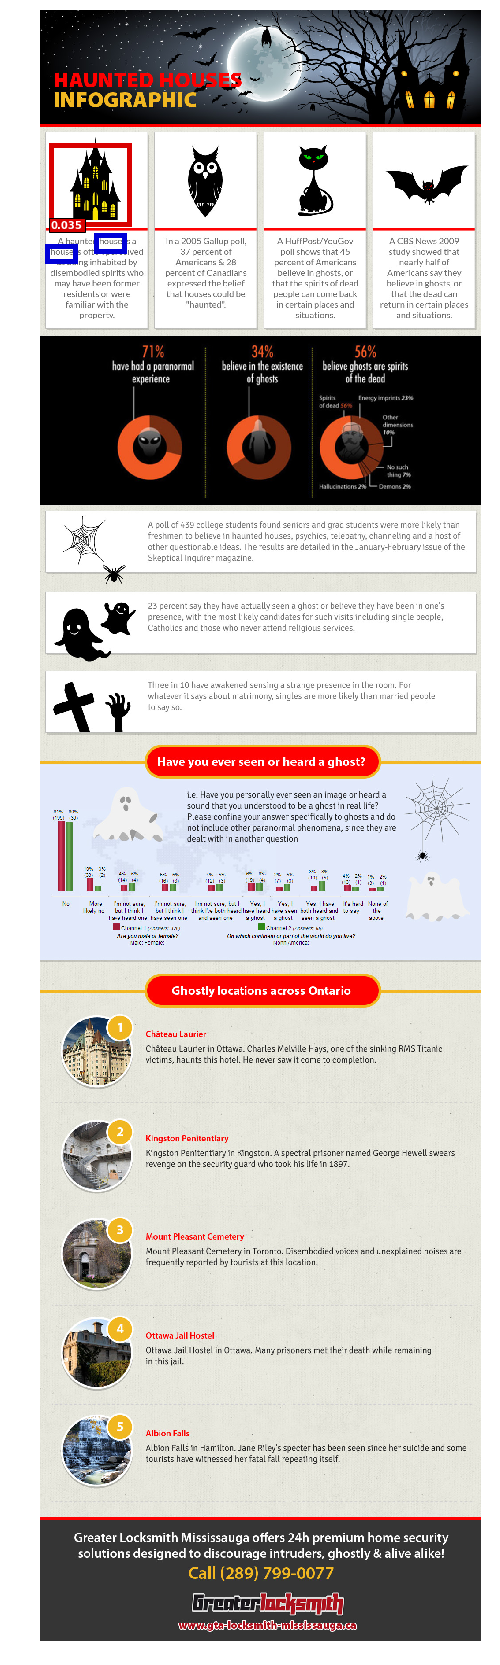

{'icons': [{'confidence': '0.035',
   'height': 178,
   'left': 25,
   'top': 307,
   'width': 178}],
 'text': [{'h': 37, 'w': 63, 'x_min': 127, 'y_min': 510},
  {'h': 35, 'w': 63, 'x_min': 17, 'y_min': 535}]}

In [8]:
# show a sample infographic with text and icons matching
tag_id = 175
curfile = 'haunted-house-infographic_5372059809b0c.jpg'

allkeys = list(ocr.keys())
locs_of_words = ocr[curfile][1:]
just_words = [elem[0].lower() for elem in locs_of_words]
curtag = tag_map[tag_id] 
print('tag: %s'%(curtag))

boxes_to_keep = get_icon_boxes(detectionsList[curfile],tag_id)

# get the locations of matching extracted text
inds = [i for i in range(len(just_words)) if just_words[i]==curtag]
matching_words = [locs_of_words[i] for i in inds]

PARAMS = {'thresh':0, 'textpriority':True, 'plot':True}
plot_relevant_detections(IMDIR,curfile,matching_words,boxes_to_keep,PARAMS)

In [9]:
# This script saves to a file a Dictionary mapping tags to infographics containing them, along with all the 
# text and icon bounding box coordinates.
# Note: this code skips infographics where there is no text detected that matches the tag (textpriority:True). 
# Set textpriority to False if you want to include infographics that might have matching icons even without 
# matching text. Thresh is set to only include icons with classifiation accuracy above threshold. 
# Plot set to False if just saving plots, no need to plot in-line. Set to True for debugging/visualization purposes.
PARAMS = {'thresh':0, 'textpriority':True, 'plot':False}
debug = True # if in debug, will avoid saving files, but will print some statements
Dict_keys_tofiles = {}

allkeys = list(ocr.keys())

for i in range(2): # range(len(allkeys)) # replace with full range
    
    if i%500==0:
        # save dictionary after every 500 infographics (to avoid losing partial work)
        if not debug:
            pickle.dump( Dict_keys_tofiles, open( "Dictionary_words_to_relevant_infographics.pickle", "wb" ) )
        print(i)
    
    curfile = allkeys[i]
    
    if curfile not in detectionsList:
        if debug:
            print('Skipping %s'%(curfile))
        continue
    
    for tag_id in range(len(tag_map)):
        curtag = tag_map[tag_id] 
        
        # skip over infographics that were processed
        if curtag in Dict_keys_tofiles and curfile in Dict_keys_tofiles[curtag]:
            if debug:
                print('Done this: %s'%(curfile))
            break; # skip this infographic

        boxes_to_keep = get_icon_boxes(detectionsList[curfile],tag_id)

        # get the locations of matching extracted text
        locs_of_words = ocr[curfile][1:]
        just_words = [elem[0].lower() for elem in locs_of_words]
        inds = [i for i in range(len(just_words)) if just_words[i]==curtag]
        matching_words = [locs_of_words[i] for i in inds]

        res = plot_relevant_detections(IMDIR,curfile,matching_words,boxes_to_keep,PARAMS)

        if res:
            if curtag not in Dict_keys_tofiles:
                Dict_keys_tofiles[curtag] = {}
            Dict_keys_tofiles[curtag][curfile] = res


0


## Now plot & save the infographics matching each tag: ##

In [10]:
# if starting here, run the first cell of this file to get the necessary imports and paths

D = pickle.load(open("Dictionary_words_to_relevant_infographics.pickle", "rb"))
infographicList = pickle.load(open("infographics60K_metadata.pckl", "rb"))

In [11]:
# Function for choosing which infographics to output first for each tag:
# this one calculates for each infographic the total area covered by detected text & images (bounding boxes) 
# matching the tag. Consider replacing with your own function if you have a better idea for which infographics 
# to display for each tag. 

def sort_infographics(D,curtag):

    matching_files = D[curtag]

    tot_areas = [None]*len(matching_files)
    all_files = [None]*len(matching_files)

    i = 0
    for curfile in matching_files:

        im = Image.open(os.path.join(IMDIR,curfile))
        W,H = im.size

        matching_words = D[curtag][curfile]['text']
        matching_icons = D[curtag][curfile]['icons']

        # compute total bounding box area covered by OCR text matching tag
        text_area = 1
        for box in matching_words:
            text_area += box['w']*box['h']

        # compute total bounding box area covered by detected icons matching tag
        icon_area = 1
        for bb in matching_icons:
            icon_area += bb['width']*bb['height']

        tot_areas[i] = (text_area + icon_area)/float(W*H) # normalized area of image
        all_files[i] = curfile
        i += 1
        
    return (tot_areas,all_files)
    

0: health


/data/graphics/graphicdesignImportance/libs/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


The actual tags of the infographic:
['health', 'data', 'big data', 'forbes', 'america']


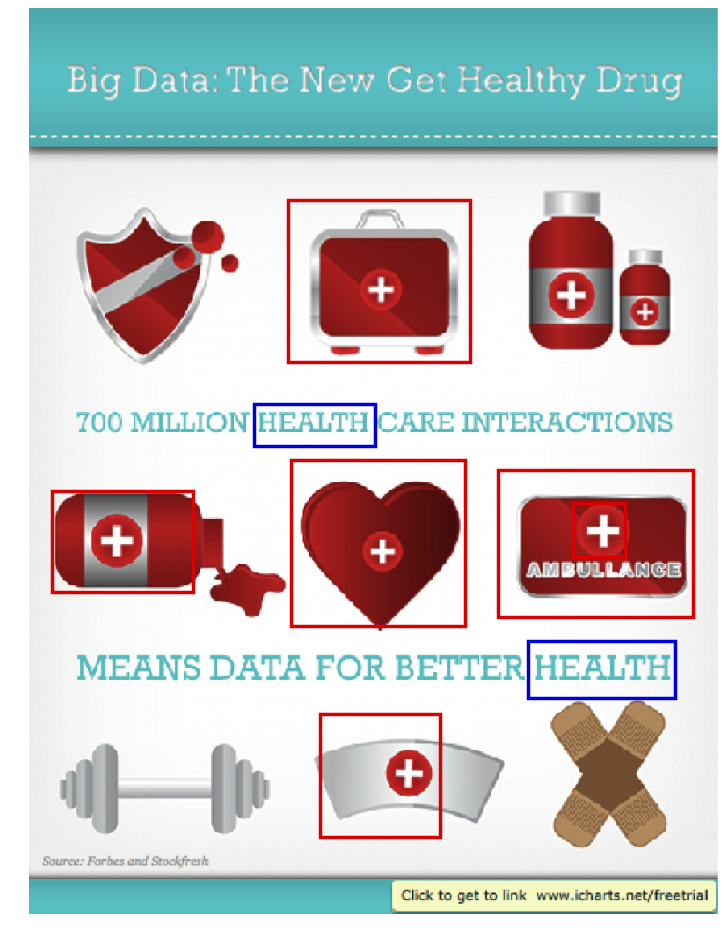

DONE!


In [13]:
Ntop = 30   # how many infographics to display for each tag
top = True  # else plot bottom (worst matches, for demo/debuging/visualization purposes)
lwidth = 5  # thickness of bounding boxes
my_dpi = 50 # DPI for displaying infographics
debug = True # if in debug mode, will plot results instead of saving them to files

allnames = [infographicList[i].imname for i in range(len(infographicList))]

if not os.path.exists('TOP30perTAG'): # this is where the plotted infographics will be saved
    os.makedirs('TOP30perTAG')
    
allkeys = [key for key in D.keys()]

ii = 0
for c in range(1): # range(len(allkeys)) # replace with full range to plot all

    curtag = allkeys[c]
    print('%d: %s'%(c,curtag))
    ii += 1
    
    (tot_areas,all_files) = sort_infographics(D,curtag)
    # sort:
    idx = np.argsort(tot_areas)
    if top: 
        idx = idx[::-1]
    
    thistag = curtag.replace(' ','_')
    tagdir = os.path.join('TOP30perTAG',thistag)
    
    if not os.path.exists(tagdir):
        os.makedirs(tagdir)
        
    jsonobj = Ntop*[None]

    jj = 0
    Nchosen = 0
    # make sure to output Ntop files
    while Nchosen < Ntop and jj < len(all_files):

        curfile = all_files[idx[jj]]
        jj += 1
        
        if curfile not in allnames:
            if debug:
                print('skipping file not found %s'%(curfile))
            continue
            
        im = Image.open(os.path.join(IMDIR,curfile))    
        W,H = im.size
        if H > W*4 or W > H*4:
            if debug:
                print('skipping big image %s'%(curfile))
            continue
            
        # store in a corresponding json file the title and URL of the infographic
        curid = allnames.index(curfile)
        jsonobj[Nchosen] = {'name':'%02d.png'%(Nchosen),
                            'url':infographicList[curid].mainurl,
                            'title':infographicList[curid].title}
        
        # note, the infographic might not have been tagged by the given term, 
        # even if it occurs within the text of the infographic or as an icon
        if debug:
            print('The actual tags of the infographic:') 
            print(infographicList[curid].tags)
        
        fig,ax = plt.subplots(1,figsize=(1200/my_dpi, 1200/my_dpi), dpi=my_dpi); #figsize=(50,30));
        ax.imshow(im); plt.axis('off');

        matching_words = D[curtag][curfile]['text']
        matching_icons = D[curtag][curfile]['icons']

        # plot matching text
        for box in matching_words:
            rect = patches.Rectangle((box['x_min'], box['y_min']), box['w'], box['h'], facecolor='none',linewidth=lwidth,edgecolor=(0.0, 0.0, 0.84839019607843136, 1.0))
            ax.add_patch(rect)

        # plot matching icons
        # convert coordinates of bounding box from normalized coordinates to rectangle coordinates
        for bb in matching_icons:

            rect_icon = patches.Rectangle((bb['left'],bb['top']), bb['width'], bb['height'], facecolor='none',linewidth=lwidth,edgecolor=(0.84839019607843136, 0.0, 0.0, 1.0))
            ax.add_patch(rect_icon)
            bottom = bb['top']+bb['height']
            # uncomment the below text if you also want the classification confidence scores displayed
            # ax.text(bb['left'], bottom+10, '%s'%(bb['confidence']), \
            #            size = 10, weight = 'bold', color='white', \
            #            bbox={'facecolor':(0.84839019607843136, 0.0, 0.0, 1.0), 'alpha':1, 'pad':2})


        if debug:  
            plt.show()
            break # only show first matching infographic to avoid overflowing the notebook
        else:
            plt.savefig(os.path.join(tagdir,'%02d.png'%(Nchosen)), bbox_inches='tight', dpi=100) # 50
            plt.close(fig)

            with open(os.path.join(tagdir,'data.json'), 'w') as outfile:
                json.dump(jsonobj, outfile)
            
        Nchosen += 1

print('DONE!')